In [8]:
import pandas as pd 
import numpy as np 
import glob
import matplotlib.pyplot as plt 
from textblob import TextBlob
import seaborn as sns 
import nltk
import string
from collections import Counter
import graphviz

import sklearn as sk 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 

In [2]:
article_file = glob.glob("Articles*.csv")
comment_file = glob.glob('Comments*.csv')
article_file

['ArticlesApril2017.csv',
 'ArticlesApril2018.csv',
 'ArticlesFeb2017.csv',
 'ArticlesFeb2018.csv',
 'ArticlesJan2017.csv',
 'ArticlesJan2018.csv',
 'ArticlesMarch2017.csv',
 'ArticlesMarch2018.csv',
 'ArticlesMay2017.csv']

In [3]:
# TO DO: Make this parallel 
comments= pd.read_csv('CommentsApril2018.csv')

C:\Users\timrc\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Text pre-processing 
def preprocess(commentBody):
    commentBody = commentBody.str.replace("(<br/>)", "")
    commentBody = commentBody.str.replace('(<a).*(>).*(</a>)', '')
    commentBody = commentBody.str.replace('(&amp)', '')
    commentBody = commentBody.str.replace('(&gt)', '')
    commentBody = commentBody.str.replace('(&lt)', '')
    commentBody = commentBody.str.replace('(\xa0)', ' ')  
    return commentBody
comments.commentBody = preprocess(comments.commentBody)

In [5]:
# Drop null columns 
comments.commentBody = preprocess(comments.commentBody)
comments.drop(['commentTitle', 'recommendedFlag', 'reportAbuseFlag', 'userURL'], axis=1, inplace=True)

In [7]:
# Describe on non-quant data 
describe = comments.describe(include=['O']).T
describe

,count,unique,top,freq
articleID,264924,1351,5acbc4e2068401528a2a5a2c,3823
commentBody,264924,264153,Well said.,27
commentType,264924,3,comment,181009
newDesk,264924,39,OpEd,84665
parentUserDisplayName,83875,17664,Richard Luettgen,475
permID,264904,264904,26772854,1
picURL,264924,6708,https://graphics8.nytimes.com/images/apps/time...,115937
sectionName,264924,36,Unknown,147300
status,264924,1,approved,264924
typeOfMaterial,264924,8,News,164877


In [8]:
# Describe numeric data 
comments.describe().T

,count,mean,std,min,25%,50%,75%,max
approveDate,264924.0,1.523844e+09,7.815543e+05,1.522344e+09,1.523278e+09,1.523882e+09,1.524516e+09,1.525233e+09
articleWordCount,264924.0,1.358169e+03,9.021956e+02,5.300000e+01,9.040000e+02,1.208000e+03,1.472000e+03,9.887000e+03
commentID,264924.0,2.674474e+07,1.144032e+05,2.653117e+07,2.664844e+07,2.674923e+07,2.684227e+07,2.694126e+07
commentSequence,264924.0,2.674474e+07,1.144032e+05,2.653117e+07,2.664844e+07,2.674923e+07,2.684227e+07,2.694126e+07
createDate,264924.0,1.523837e+09,7.819454e+05,1.522344e+09,1.523249e+09,1.523852e+09,1.524515e+09,1.525233e+09
depth,264924.0,1.338561e+00,5.185143e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00
inReplyTo,264924.0,8.470858e+06,1.244170e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.662660e+07,2.694099e+07
parentID,264924.0,8.470858e+06,1.244170e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.662660e+07,2.694099e+07
printPage,264924.0,8.187299e+00,1.043908e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.600000e+01,1.090000e+02
recommendations,264924.0,1.859889e+01,8.999093e+01,0.000000e+00,1.000000e+00,4.000000e+00,1.200000e+01,8.713000e+03


In [111]:
# Drop all rows with empty comment bodies: 
a = comments[comments['commentBody'] == ''].index.to_list()
for i in a: 
    comments.drop(index = [i], axis = 0, inplace = True)
comments.head()

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentType,createDate,depth,editorsSelection,...,status,timespeople,trusted,typeOfMaterial,updateDate,userDisplayName,userID,userLocation,userTitle,sentiment
0,1524594282,5adf6684068401528a2aa69b,781.0,How could the league possibly refuse this offe...,26853969.0,26853969.0,comment,1524594011,1.0,False,...,approved,1,0,News,1524594282,Christopher Rillo,46566740.0,San Francisco,NaN,0.000000
1,1524594252,5adf6684068401528a2aa69b,781.0,"So then the execs can be like ""yeah...we will ...",26853699.0,26853699.0,comment,1524593146,1.0,False,...,approved,1,0,News,1524594252,Matt Brand,64324866.0,"Williamsburg, Brooklyn",NaN,-0.155556
2,1524594250,5adf6684068401528a2aa69b,781.0,I would not want to play chess against these c...,26853677.0,26853677.0,comment,1524593032,1.0,False,...,approved,1,0,News,1524594250,Joseph,78105093.0,"Fayetteville, AR",NaN,0.000000
3,1524593431,5adf6684068401528a2aa69b,781.0,Could the cheerleaders join the Actors' Equity...,26853784.0,26853784.0,comment,1524593426,1.0,False,...,approved,0,0,News,1524593431,Stephen,81939618.0,"Phoenix, AZ",NaN,0.100000
4,1524595048,5adf653f068401528a2aa697,656.0,Seeking conclusions which support preconceived...,26854236.0,26854236.0,comment,1524595043,1.0,False,...,approved,1,0,News,1524595048,Paul Zorsky,58642997.0,Texas,NaN,0.012857


In [7]:
%%time 
# Sentiment analysis: 
comments['sentiment'] = comments.commentBody.map(lambda text: TextBlob(text).sentiment.polarity)

Wall time: 2min 4s


In [9]:
# Printing the 5 highest sentiment comments: 
high_sent = comments.nlargest(5, columns = ['sentiment'])
high_sent['commentBody'].values

array(['Overseeing a hostile work environment?  Sounds perfectly will qualified for a job in or around the Trump administration.',
       'The best people, folks. The best.',
       '"Nothing but the best people..."*Sigh*',
       'Yep, he is perfect for this do-as-I-say-not-as-I-do administration. ',
       'VERY good question!'], dtype=object)

In [10]:
# Printing the 5 lowest sentiment comments: 

low_sent = comments.nsmallest(5, columns = ['sentiment'])
display(low_sent['commentBody'].values )

array(['kakistocracy[kak-uh-stok-ruh-see]noun, plural kak·is·toc·ra·cies.government by the worst persons; a form of government in which the worst persons are in power.',
       'How insulting to our veterans. ',
       'Oh my god.  What an ordeal. Terrifying.  ',
       'Tennessee may be among the worst states for allowing unfettered access to guns, but there is nowhere in America that a person can escape this scourge.',
       'Evil people with killer physic powers?  No guns needed, I have not heard that one.'],
      dtype=object)

C:\Users\timrc\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


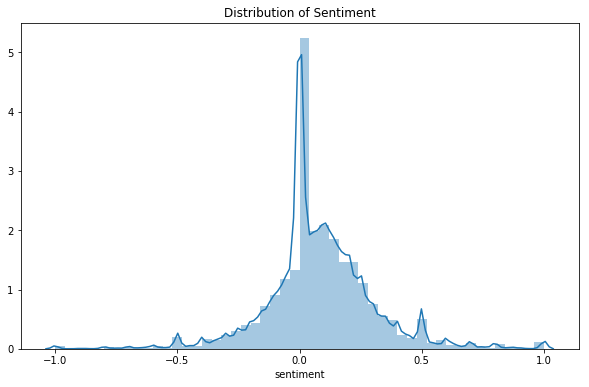

In [11]:
# Plot sentiment distribution: 

plt.figure(figsize = (10, 6))
plt.title('Distribution of Sentiment')
sns.distplot(comments['sentiment'])

C:\Users\timrc\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


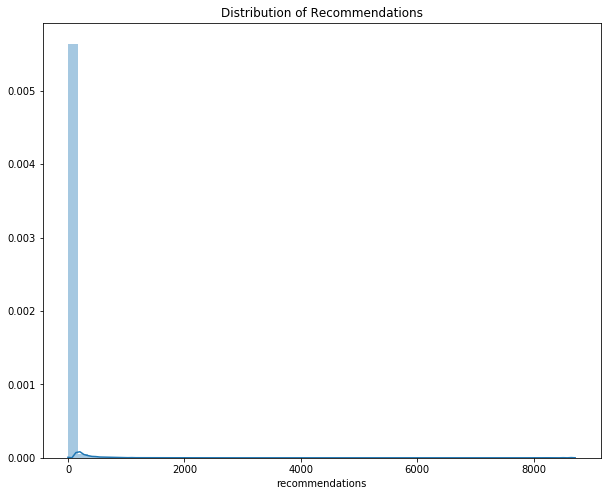

In [12]:
# Plot distribution of recommendations: 

plt.figure(figsize = (10, 8))
plt.title("Distribution of Recommendations")
sns.distplot(comments.recommendations)

C:\Users\timrc\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


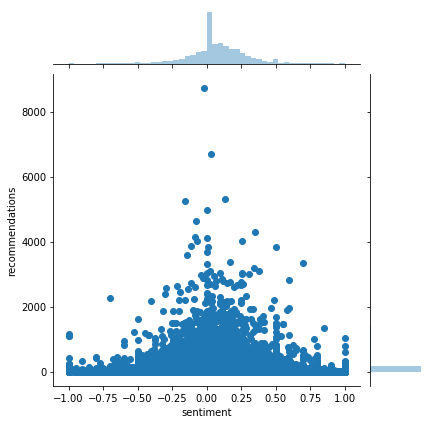

In [13]:
# Plot Sentiment vs. Recommendations: 

sns.jointplot(comments.sentiment, comments.recommendations)

In [95]:
subset = round(len(comments['sentiment'])*.1) #The top 10% highest and lowest sentiment comments will be judged
subset

26490

In [96]:
high_sent = comments.nlargest(100, columns = ['sentiment'])
low_sent = comments.nsmallest(100, columns = ['sentiment'])

In [97]:
import operator
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer()

In [98]:
%%time
words = []
wordlist = []
highwordcount = {}
for comment in high_sent['commentBody']: #For loop to tokenize, remove punctuation and stopwords and to stem words
    toks = nltk.wordpunct_tokenize(comment)
    words.append([stemmer.stem(t.lower()) for t in toks if (t not in string.punctuation and t.lower() not in stopwords)])
for sublist in words: #For loop to make a list of lists into a list
    for item in sublist:
        wordlist.append(item)

Wall time: 13.9 ms


In [99]:
%%time
words2 = []
wordlist2 = []
lowwordcount = {}
for comment2 in low_sent['commentBody']:
    toks2 = nltk.wordpunct_tokenize(comment2)
    words2.append([stemmer.stem(t.lower()) for t in toks2 if (t not in string.punctuation and t.lower() not in stopwords)])
for sublist2 in words2:
    for item2 in sublist2:
        wordlist2.append(item2)


Wall time: 19.3 ms


In [100]:
#Remove common words between the two lists
uniquehighsent = [x for x in wordlist if x not in wordlist2]
uniquelowsent = [x for x in wordlist2 if x not in wordlist]
print(len(uniquehighsent))
print(len(uniquelowsent))

467
752


In [101]:
highs = {w: 1 if w not in highwordcount and not highwordcount.update({w: 1}) #Makes a dictionary with words as keys and counts as values
                  else highwordcount[w] + 1
                  if not highwordcount.update({w: highwordcount[w] + 1}) else 1 for w in uniquehighsent}

In [102]:
lows = {x: 1 if x not in lowwordcount and not lowwordcount.update({x: 1})
                  else lowwordcount[x] + 1
                  if not lowwordcount.update({x: lowwordcount[x] + 1}) else 1 for x in uniquelowsent}

In [103]:
sorted_highwordcount = list(reversed(sorted(highwordcount.items(), key=operator.itemgetter(1)))) #Sorts the dictionary by values
sorted_lowwordcount = list(reversed(sorted(lowwordcount.items(), key=operator.itemgetter(1))))

In [104]:
sorted_highwordcount[:15]

[('best', 32),
 ('excel', 17),
 ('perfect', 15),
 ('great', 9),
 ('articl', 7),
 ('point', 6),
 ('mueller', 5),
 ('happi', 5),
 ('rate', 4),
 ('report', 4),
 ('brilliant', 4),
 ('greatest', 4),
 ('job', 4),
 ('matter', 3),
 ('."', 3)]

In [105]:
sorted_lowwordcount[:15]

[('worst', 28),
 ('terribl', 13),
 ('evil', 12),
 ('horribl', 9),
 ('pathet', 8),
 ('disgust', 8),
 ('comey', 7),
 ('run', 6),
 ('insan', 6),
 ('histori', 5),
 ('world', 5),
 ('nasti', 5),
 ('yes', 5),
 ('aw', 5),
 ('use', 5)]

In [26]:
bestwords = list(zip(*sorted_highwordcount[:15])).pop(0)
worstwords = list(zip(*sorted_lowwordcount[:15])).pop(0)

In [27]:
def word_freq(words,comment):
    wrds=[]
    toks = nltk.wordpunct_tokenize(comment)
    wrds.append([stemmer.stem(t.lower()) for t in toks if (t not in string.punctuation and t.lower() not in stopwords)])
    wlist = ' '.join(str(i) for i in wrds)
    worddict = {}
    if len(comment.split()) == 0:
        return 0
    else:
        for word in words:
            worddict[f"freq_{word}"] = wlist.count(word)/len(comment.split()) 
    return worddict


In [28]:
# Best word freq
bestwordfreq = []
for i in comments['commentBody']:
    x = word_freq(bestwords,i)
    bestwordfreq.append(x)
bestwordfreq = pd.DataFrame(bestwordfreq)

In [73]:
bestwordfreq.drop(bestwordfreq.columns[0], axis = 1, inplace = True)
bestwordfreq['articleWordCount'] = comments.articleWordCount
bestwordfreq['depth'] = comments.depth
bestwordfreq['Target'] = comments.editorsSelection
bestwordfreq.dropna(inplace = True)
bestwordfreq.head()

,freq_greatest,freq_happi,freq_job,freq_matter,freq_mueller,freq_perfect,freq_point,freq_rate,freq_report,articleWordCount,depth,Target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,781.0,1.0,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,781.0,1.0,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,781.0,1.0,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,781.0,1.0,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,656.0,1.0,False


In [148]:
x = bestwordfreq.drop(columns = ['Target'])
y = bestwordfreq.Target

In [211]:
accuracy = []
feature_imp = []
y_ps = []
truesums = []
for i in range(200): 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .30)
    tree = DecisionTreeClassifier(max_depth = 10)
    tree.fit(x_train, y_train.astype(int))
    accuracy.append(tree.score(x_test, y_test.astype(int))) 
    feature_imp.append(tree.feature_importances_)
    y_ps.append(tree.predict(x_test))
    truesums.append(np.sum(tree.predict(x_test)))

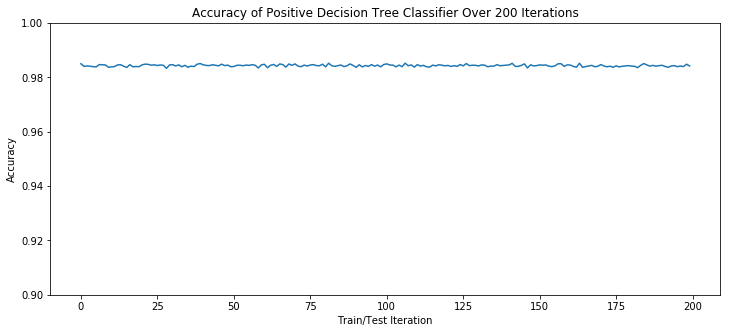

Mean Accuracy = 0.9843240250179329Standard Deviation = 0.0003780276905044141


In [123]:
# Plotting the accuracy over each iteration: 

import matplotlib.pyplot as plt 
plt.figure(figsize = (12,5))
plt.ylim(.90, 1)
plt.title("Accuracy of Positive Decision Tree Classifier Over 200 Iterations")
plt.xlabel("Train/Test Iteration")
plt.ylabel("Accuracy")
plt.plot(accuracy)
plt.show()

mean_accuracy = np.mean(accuracy, axis = 0)
deviation = np.std(accuracy, axis = 0)

print(f'Mean Accuracy = {mean_accuracy}' + f'Standard Deviation = {deviation}') # accuracy/stdev over iterations 

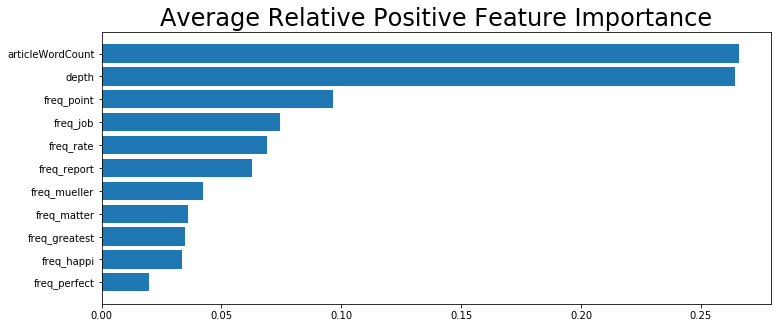

In [124]:
# Plotting Sorted Feature Importances for Decision Tree

imps = np.mean(feature_imp, axis=0)
I = np.argsort(imps)
imps_sorted = imps[I]
cols_sorted = x.columns[I]
plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.set_title("Average Relative Positive Feature Importance", fontsize=24)
ax.barh(cols_sorted, imps_sorted)
ax.set_yticklabels(cols_sorted, fontsize=10)
plt.show()

In [149]:
from sklearn.ensemble import RandomForestClassifier 

accuracy = []
feature_imp = []
for i in range(100): 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .30)
    forest = RandomForestClassifier(n_estimators = 10) 
    forest.fit(x_train, y_train.astype(int))
    accuracy.append(forest.score(x_test, y_test.astype(int)))
    feature_imp.append(forest.feature_importances_)

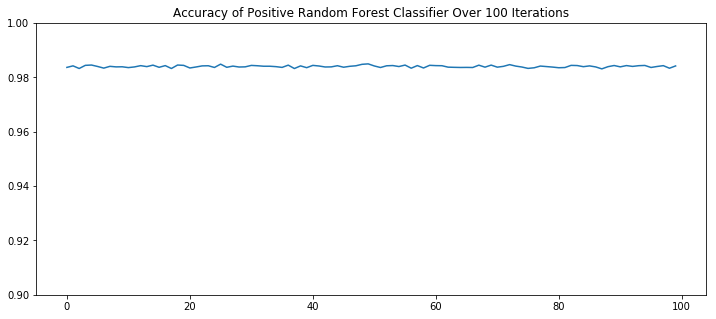

Mean Accuracy = 0.9840100424096748Standard Deviation = 0.0003891549517045396


In [150]:
# Plotting the accuracy over each iteration: 

import matplotlib.pyplot as plt 
plt.figure(figsize = (12,5))
plt.ylim(.90, 1)
plt.title("Accuracy of Positive Random Forest Classifier Over 100 Iterations")
plt.plot(accuracy)
plt.show()

mean_accuracy = np.mean(accuracy, axis = 0)
deviation = np.std(accuracy, axis = 0)

print(f'Mean Accuracy = {mean_accuracy}' + f'Standard Deviation = {deviation}') # accuracy/stdev over iterations 

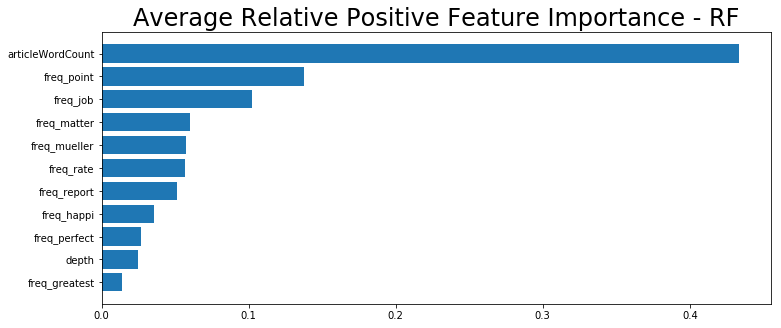

In [151]:
# Plotting Sorted Feature Importances for Decision Tree

imps = np.mean(feature_imp, axis=0)
I = np.argsort(imps)
imps_sorted = imps[I]
cols_sorted = x.columns[I]
plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.set_title("Average Relative Positive Feature Importance - RF", fontsize=24)
ax.barh(cols_sorted, imps_sorted)
ax.set_yticklabels(cols_sorted, fontsize=10)
plt.show()

In [52]:
# Worst word freq
worstwordfreq = []
for i in comments['commentBody']:
    x = word_freq(worstwords,i)
    worstwordfreq.append(x)
worstwordfreq = pd.DataFrame(worstwordfreq)

In [136]:
worstwordfreq['articleWordCount'] = comments.articleWordCount
worstwordfreq['depth'] = comments.depth
worstwordfreq['Target'] = comments.editorsSelection
worstwordfreq.dropna(inplace = True)
worstwordfreq.head()

,freq_aw,freq_comey,freq_disgust,freq_evil,freq_histori,freq_horribl,freq_insan,freq_nasti,freq_pathet,freq_run,freq_terribl,freq_use,freq_world,freq_worst,freq_yes,articleWordCount,depth,Target
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,781.0,1.0,False
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,781.0,1.0,False
2,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,781.0,1.0,False
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,781.0,1.0,False
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011236,0.0,0.0,0.0,656.0,1.0,False


In [137]:
x = worstwordfreq.drop(columns = ['Target'])
y = worstwordfreq.Target

In [138]:
accuracy = []
feature_imp = []
y_ps = []
for i in range(200): 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .30)
    tree = DecisionTreeClassifier(max_depth = 10)
    tree.fit(x_train, y_train.astype(int))
    accuracy.append(tree.score(x_test, y_test.astype(int))) 
    feature_imp.append(tree.feature_importances_)
    y_ps.append(tree.predict(x_test))

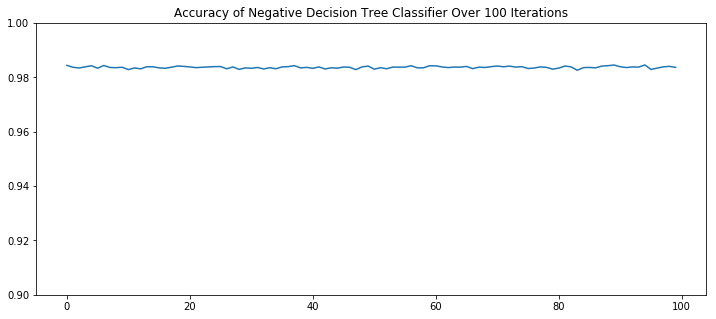

Mean Accuracy = 0.9836910260121061Standard Deviation = 0.000391965112621466


In [143]:
# Plotting the accuracy over each iteration: 

import matplotlib.pyplot as plt 
plt.figure(figsize = (12,5))
plt.ylim(.90, 1)
plt.title("Accuracy of Negative Decision Tree Classifier Over 100 Iterations")
plt.plot(accuracy)
plt.show()

mean_accuracy = np.mean(accuracy, axis = 0)
deviation = np.std(accuracy, axis = 0)

print(f'Mean Accuracy = {mean_accuracy}' + f'Standard Deviation = {deviation}') # accuracy/stdev over iterations 

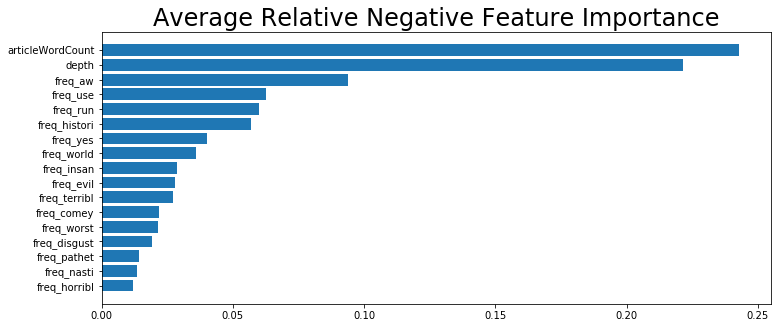

In [140]:
# Plotting Sorted Feature Importances for Decision Tree

imps = np.mean(feature_imp, axis=0)
I = np.argsort(imps)
imps_sorted = imps[I]
cols_sorted = x.columns[I]
plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.set_title("Average Relative Negative Feature Importance", fontsize=24)
ax.barh(cols_sorted, imps_sorted)
ax.set_yticklabels(cols_sorted, fontsize=10)
plt.show()

In [144]:
from sklearn.ensemble import RandomForestClassifier 

accuracy = []
feature_imp = []
for i in range(100): 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .30)
    forest = RandomForestClassifier(n_estimators = 10) 
    forest.fit(x_train, y_train.astype(int))
    accuracy.append(forest.score(x_test, y_test.astype(int)))
    feature_imp.append(forest.feature_importances_)

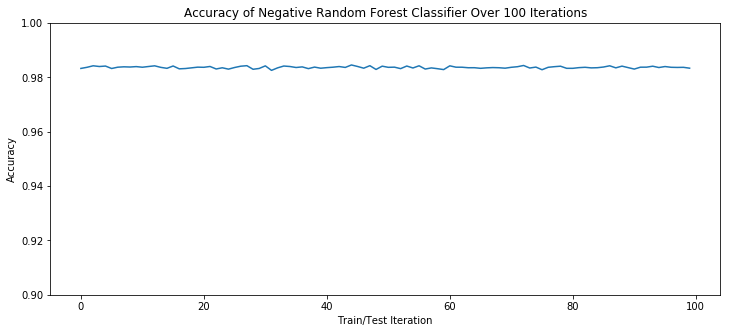

Mean Accuracy = 0.9836691290286045Standard Deviation = 0.000389507236550285


In [145]:
# Plotting the accuracy over each iteration: 

import matplotlib.pyplot as plt 
plt.figure(figsize = (12,5))
plt.ylim(.90, 1)
plt.title("Accuracy of Negative Random Forest Classifier Over 100 Iterations")
plt.xlabel("Train/Test Iteration")
plt.ylabel("Accuracy")
plt.plot(accuracy)
plt.show()

mean_accuracy = np.mean(accuracy, axis = 0)
deviation = np.std(accuracy, axis = 0)

print(f'Mean Accuracy = {mean_accuracy}' + f'Standard Deviation = {deviation}') # accuracy/stdev over iterations 

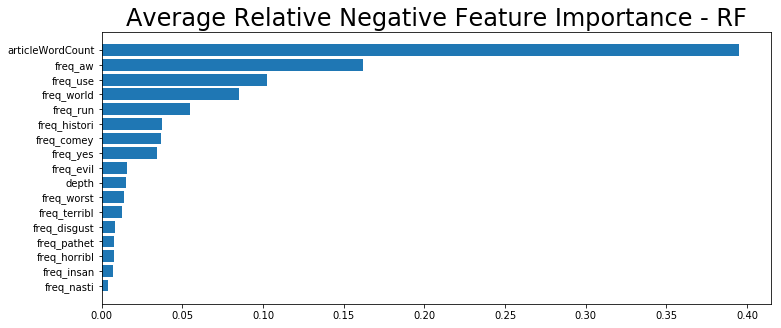

In [146]:
# Plotting Sorted Feature Importances for Random Forest: 

imps = np.mean(feature_imp, axis=0)
I = np.argsort(imps)
imps_sorted = imps[I]
cols_sorted = x.columns[I]
plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.set_title("Average Relative Negative Feature Importance - RF", fontsize=24)
ax.barh(cols_sorted, imps_sorted)
ax.set_yticklabels(cols_sorted, fontsize=10)
plt.show()

In [156]:
# To do: Make new DF of top 3 most important positive/negative 

df1 = bestwordfreq[['articleWordCount', 'freq_point', 'freq_job', 'Target']]
df2 = worstwordfreq[['freq_aw', 'freq_use']]
final_df = df1.join(df2)
final_df.head()

,articleWordCount,freq_point,freq_job,Target,freq_aw,freq_use
0,781.0,0.0,0.0,False,0.000000,0.000000
1,781.0,0.0,0.0,False,0.000000,0.000000
2,781.0,0.0,0.0,False,0.083333,0.000000
3,781.0,0.0,0.0,False,0.000000,0.000000
4,656.0,0.0,0.0,False,0.000000,0.011236


In [213]:
x = final_df.drop(columns = 'Target')
y = final_df.Target

In [214]:
accuracy_final = []
feat_imp_final = [] 
truesums = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .30)
    final_forest = RandomForestClassifier(n_estimators = 10)
    final_forest.fit(x_train, y_train)
    accuracy_final.append(final_forest.score(x_test, y_test))
    feat_imp_final.append(final_forest.feature_importances_)
    y_p = final_forest.predict(x_test)
    truesums.append(sum(y_p))

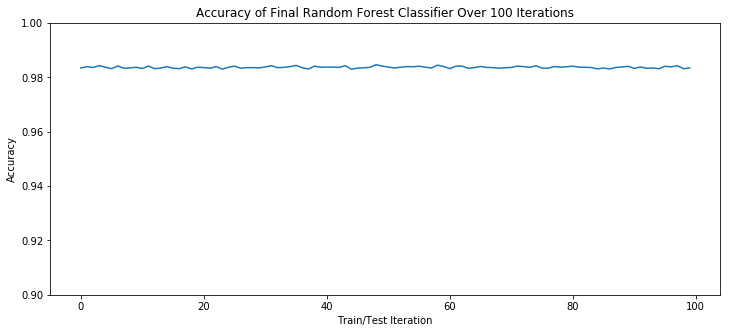

Mean Accuracy = 0.9836987025408049Standard Deviation = 0.0003596402697865443


In [215]:
plt.figure(figsize = (12,5))
plt.ylim(.90, 1)
plt.title("Accuracy of Final Random Forest Classifier Over 100 Iterations")
plt.xlabel("Train/Test Iteration")
plt.ylabel("Accuracy")
plt.plot(accuracy_final)
plt.show()

mean_accuracy = np.mean(accuracy_final, axis = 0)
deviation = np.std(accuracy_final, axis = 0)

print(f'Mean Accuracy = {mean_accuracy}' + f'Standard Deviation = {deviation}') # accuracy/stdev over iterations 

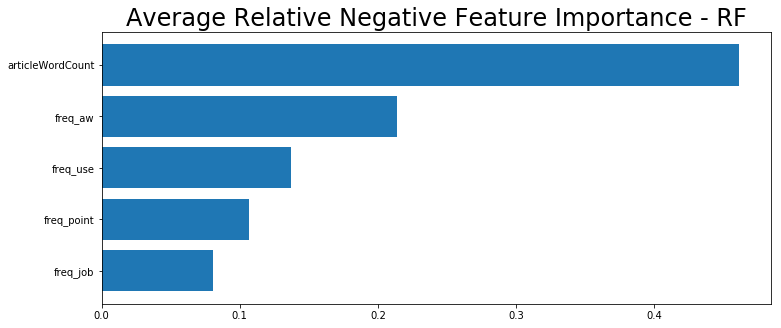

In [216]:
# Plotting Sorted Feature Importances for Final Random Forest: 

imps = np.mean(feat_imp_final, axis=0)
I = np.argsort(imps)
imps_sorted = imps[I]
cols_sorted = x.columns[I]
plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.set_title("Average Relative Negative Feature Importance - RF", fontsize=24)
ax.barh(cols_sorted, imps_sorted)
ax.set_yticklabels(cols_sorted, fontsize=10)
plt.show()

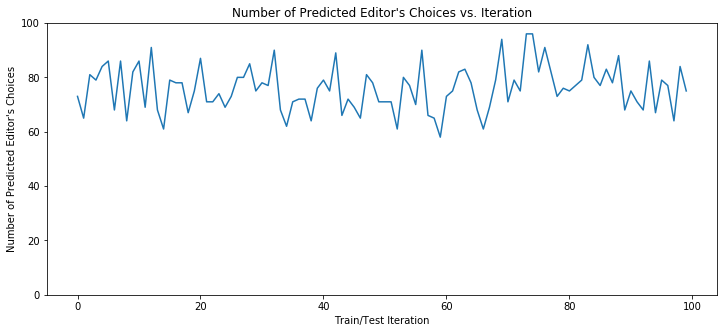

In [223]:
plt.figure(figsize = (12,5))
plt.ylim(0, 100)
plt.title("Number of Predicted Editor's Choices vs. Iteration")
plt.xlabel("Train/Test Iteration")
plt.ylabel("Number of Predicted Editor's Choices")
plt.plot(truesums)
plt.show()

### Final Validation - Using March 2018 Data

In [226]:
mar_comments = pd.read_csv('CommentsMarch2018.csv')
mar_comments.commentBody = preprocess(feb_comments.commentBody)
mar_comments.drop(['commentTitle', 'recommendedFlag', 'reportAbuseFlag', 'userURL'], axis=1, inplace=True)

C:\Users\timrc\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14,15,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [227]:
# Drop all rows with empty comment bodies: 
a = mar_comments[mar_comments['commentBody'] == ''].index.to_list()

for i in a: 
    mar_comments.drop(index = [i], axis = 0, inplace = True)
mar_comments.head()

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentType,createDate,depth,editorsSelection,...,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,typeOfMaterial
0,1520043821,5a974697410cf7000162e8a4,1207,If the choice is between mining for bitcoin - ...,26188943.0,26188943.0,comment,1520029445,1.0,0,...,1,approved,1,0,1520043821,Steve,46903103.0,Florida,NaN,News
1,1520043790,5a974697410cf7000162e8a4,1207,"To me, Bitcoin (et al) appears to be an expens...",26189292.0,26189292.0,comment,1520031265,1.0,0,...,0,approved,1,0,1520043790,MyOpinion,82778.0,NYC,NaN,News
2,1520043789,5a974697410cf7000162e8a4,1207,Bitcoin is a pyramid scheme backed by nothing ...,26189645.0,26189645.0,comment,1520033172,1.0,0,...,0,approved,1,0,1520043789,Bert Gold,3013548.0,"Frederick, Maryland",NaN,News
3,1520043788,5a974697410cf7000162e8a4,1207,What does it cost in energy to dig up and refi...,26189102.0,26189102.0,comment,1520030291,1.0,0,...,0,approved,1,0,1520043788,James Demers,70245222.0,Brooklyn,NaN,News
4,1520043787,5a974697410cf7000162e8a4,1207,You forgot to mention stock buybacks.,26189683.0,26189683.0,comment,1520033404,1.0,0,...,0,approved,1,0,1520043787,Bill,66424344.0,California,NaN,News


In [264]:
# Best word freq
bestwordfreq_mar = []
for i in mar_comments['commentBody'][0:10000]:
    x = word_freq(bestwords,i)
    bestwordfreq_mar.append(x)
bestwordfreq_mar = pd.DataFrame(bestwordfreq_mar)

In [265]:
bestwordfreq_mar['articleWordCount'] = mar_comments.articleWordCount
bestwordfreq_mar['depth'] = mar_comments.depth
bestwordfreq_mar['Target'] = mar_comments.editorsSelection
bestwordfreq_mar.dropna(inplace = True)
# bestwordfreq_mar.head()

In [266]:
worstwordfreq_mar = []
for i in mar_comments['commentBody'][0:10000]:
    x = word_freq(worstwords,i)
    worstwordfreq_mar.append(x)
worstwordfreq_mar = pd.DataFrame(worstwordfreq_mar)

In [267]:
worstwordfreq_mar['articleWordCount'] = mar_comments.articleWordCount
worstwordfreq_mar['depth'] = mar_comments.depth
worstwordfreq_mar['Target'] = mar_comments.editorsSelection
worstwordfreq_mar.dropna(inplace = True)

In [279]:
df1_mar = bestwordfreq_mar[['articleWordCount', 'freq_point', 'freq_job', 'Target']]
df2_mar = worstwordfreq_mar[['freq_aw', 'freq_use']]
final_df_mar = df1_mar.join(df2_mar)
final_df_mar_samp = final_df_mar.sample(5000)

In [280]:
x_mar = final_df_mar_samp.drop(columns = ['Target'])
y_mar = final_df_mar_samp.Target

In [281]:
final_forest.score(x_mar, y_mar)

0.9754